In [ ]:
# A RNN-based Reinforcement Learning Framework for Frequency Control Problem with Stability Guarantee
import collections
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import gym
import tensorflow as tf
import os
import random
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.layers import RNN
import tensorflow.keras.backend as K
import sys
from gym import spaces
from gym.utils import seeding
import copy
from mat4py import loadmat
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib as mpl

from cycler import cycler
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Environment Setup

In [ ]:
# Frequency Control Porblem Environment
class Frequency(gym.Env):
    def  __init__(self, Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action):
        self.param_gamma=1
        self.M=M
        self.D=D
        self.Pm=Pm
        self.max_action=max_action
        self.dim_action=dim_action
        self.omega_scale=2*np.pi # this change the unit of omega to Hz
        self.viewer = None
        self.state=[]
        self.delta_t=delta_t
        self.Penalty_action=Penalty_action
        self.state_transfer1=np.vstack((np.hstack((np.identity(dim_action,dtype=np.float32),np.zeros((dim_action,dim_action),dtype=np.float32))),\
                                np.hstack((delta_t*self.omega_scale*np.identity(dim_action,dtype=np.float32),np.identity(dim_action,dtype=np.float32)))))
        self.state_transferF=-delta_t*(((M**(-1)).reshape(dim_action,1))@np.ones((1,dim_action),dtype=np.float32))*F
        self.state_transfer2=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        np.identity(dim_action,dtype=np.float32)))        

        self.state_transfer3=np.hstack((np.zeros((1,dim_action),dtype=np.float32),\
                                        delta_t*Pm*(M**(-1))))
        self.state_transfer4=np.hstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        -delta_t*np.diag((M**(-1)))))

        self.select_add_w=np.vstack((np.zeros((dim_action,1),dtype=np.float32),\
                                        np.ones((dim_action,1),dtype=np.float32)))
        self.select_w=np.vstack((np.zeros((dim_action,dim_action),dtype=np.float32),\
                                        np.identity(dim_action,dtype=np.float32)))
        self.select_delta=np.vstack((np.identity(dim_action,dtype=np.float32),\
                                        np.zeros((dim_action,dim_action),dtype=np.float32)))
        

    def step(self, action):
        self.state=copy.deepcopy(self.state@self.state_transfer1\
                     + np.sum(np.sin( np.transpose(self.state@self.select_delta)@np.ones((1,dim_action),dtype=np.float32)-\
                        np.ones((dim_action,1),dtype=np.float32)@(self.state@self.select_delta))*self.state_transferF,axis=1 )\
                              @self.state_transfer2\
                     + self.state_transfer3\
                                 +action@self.state_transfer4)
        loss = self.param_gamma*pow(self.state,2)@self.select_add_w 
        return self.state, loss
    
    def set_state(self, state_input):
        self.state=state_input


    def reset(self):
        initial_state1=np.random.uniform(0.0,0.3,(1,self.dim_action))
        initial_state2=np.random.uniform(-0.3,0.3,(1,self.dim_action))
        s_concate=np.hstack((initial_state1,initial_state2)).astype(np.float32)
        self.state = s_concate

        return self.state
    


In [ ]:
# Simulation data load from IEEE 39-bus system
data = loadmat('IEEE_39bus_Kron.mat')

K_EN=data['Kron_39bus']['K']
K_EN=np.asarray(K_EN, dtype=np.float32)

H=data['Kron_39bus']['H']
H=np.asarray(H, dtype=np.float32)

Damp=data['Kron_39bus']['D']
Damp=np.asarray(Damp, dtype=np.float32)

omega_R=data['Kron_39bus']['omega_R']

A_EN=data['Kron_39bus']['A']
A_EN=np.asarray(A_EN, dtype=np.float32)

gamma=data['Kron_39bus']['gamma']
gamma=np.asarray(gamma, dtype=np.float32)

In [ ]:
dim_action=10 #dimension of action space
dim_state=2*dim_action #dimension of state space
delta_t=0.02
M=H.reshape(dim_action)*2/omega_R*2*np.pi
D=Damp.reshape(dim_action)/omega_R
F=K_EN

Pm=np.array([[-0.73460618, -0.35072438,  0.01231317,  0.08096456,  0.22275688,
         0.0925395 ,  0.43155028,  0.25153975,  0.33772826, -0.34316951]],dtype=np.float32)
Penalty_action=0.002
# max_action=abs(Pm)*2+np.random.uniform(0,1,(dim_action)).astype(np.float32)
max_action=np.array([[1.9475615 , 2.3011124 , 1.5449913 , 2.7024763 , 1.6764448 ,
        2.1025848 , 1.2776419 , 1.5536522 , 2.5570343 , 0.97499996]],dtype=np.float32)*1.
env = Frequency(Pm,M,D,F,delta_t,max_action,dim_action,Penalty_action)


In [ ]:
#linear droop control
def Action_linear(state,linear_coff,env):
    action_nonconstrain=(state@env.select_w)*linear_coff
    action=env.max_action-tf.nn.relu(env.max_action-action_nonconstrain)+tf.nn.relu(-env.max_action-action_nonconstrain)
    return action


In [ ]:
linear_coff0= loadmat('Sol_linear.mat')

linear_coff=linear_coff0['Sol']
linear_coff=np.asarray(linear_coff, dtype=np.float32).reshape(1,-1)

action_units=dim_action

Text(0, 0.5, 'w (p.u.)')

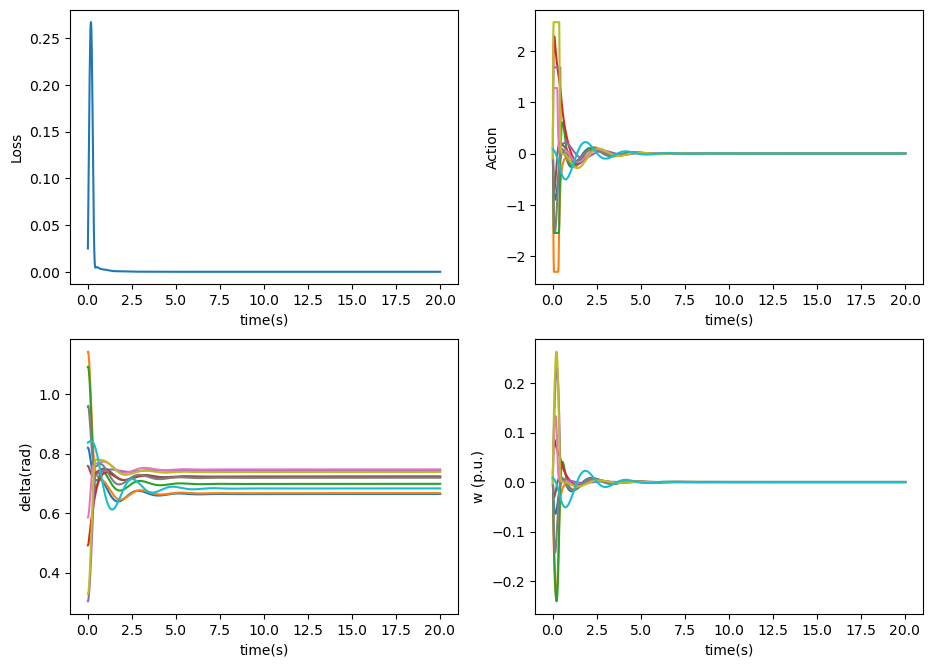

In [ ]:
# Plot the trajectory to visulize the performance of control
Trajectory_Linear=[]  
init_state=np.array([[  0.40964973,  0.5706315 ,  0.5454999 ,  0.24582419,  0.15178671,
         0.37899652,  0.2926271 ,  0.47890443,  0.16405383,  0.41809   ,
        -0.00210736,  0.00391182,  0.00452287,  0.00385107,  0.01104757,
        -0.00272085,  0.00774046,  0.01003703, -0.0014925 ,  0.00431693]],dtype=np.float32)*2
s=init_state
env.set_state(s)
Trajectory_Linear.append(s)
SimulationLength=1000
Record_u_Linear=[]
Record_Loss_Linear=[]
Loss_Linear=0
for i in range(SimulationLength):
    u=np.squeeze(Action_linear(s,linear_coff,env))
    next_s, r= env.step(u)
    Loss_Linear+=r
    s=next_s
    Trajectory_Linear.append(s)
    Record_u_Linear.append(u)
    Record_Loss_Linear.append(np.squeeze(r))

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss_Linear)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')
plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_Linear[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_Linear[:,action_units:action_units*2])
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')

In [ ]:
equilibrium_init=Trajectory_Linear[-1,:].copy()
print(equilibrium_init)

[6.6402924e-01 6.6708660e-01 6.9810122e-01 7.2109157e-01 7.4308056e-01
 7.2321033e-01 7.4677670e-01 7.1863472e-01 7.3807514e-01 6.8271470e-01
 4.2081942e-06 4.1550957e-06 4.0983286e-06 4.0522746e-06 4.0432656e-06
 4.1083208e-06 4.0653076e-06 4.2224442e-06 4.0793393e-06 4.0677537e-06]


# RNN

In [ ]:
# RNN Cell to integrate state transition dynamics
class MinimalRNNCell(keras.layers.Layer):

    def __init__(self, units,action_units,internal_units,env,batchsize,**kwargs):
        self.units = units
        self.action_units=action_units
        self.state_size = units
        self.internal_units = internal_units
        self.batchsize=batchsize
        self.state_transfer1=tf.constant(env.state_transfer1,dtype=tf.float32)
        self.state_transferF=tf.constant(env.state_transferF,dtype=tf.float32)
        self.state_transfer2=tf.constant(env.state_transfer2,dtype=tf.float32)
        self.state_transfer3=tf.constant(env.state_transfer3,dtype=tf.float32)
        self.state_transfer4=tf.constant(env.state_transfer4,dtype=tf.float32)
        self.select_add_w=tf.constant(env.select_add_w,dtype=tf.float32)
        self.select_w=tf.constant(env.select_w,dtype=tf.float32)
        self.select_delta=tf.constant(env.select_delta,dtype=tf.float32)
        self.max_action=tf.constant(env.max_action,dtype=tf.float32)
        self.Multiply_ones=tf.tile(tf.ones((action_units,action_units),dtype=np.float32)[None], [batchsize, 1, 1]) 
        self.w_recover=tf.constant(tf.linalg.band_part(-tf.ones((internal_units,internal_units)),0,1)\
                                        +2*tf.eye(internal_units),dtype=tf.float32)
        self.b_recover=tf.constant(tf.linalg.band_part(tf.ones((internal_units,internal_units)),0,-1)\
                                        -tf.eye(internal_units),dtype=tf.float32)
        self.ones_frequency=tf.ones((action_units,internal_units),dtype=tf.float32)

        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.w_plus_temp0= self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer='uniform',
            trainable=True,
            name='w_plus_temp')

        self.b_plus_temp0 = self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.1),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_plus_temp')
        self.w_minus_temp0= self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer='uniform',
            trainable=True,
            name='w_minus_temp')

        self.b_minus_temp0 = self.add_weight(
            shape=(self.action_units,self.internal_units),
            initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=0.1),
            trainable=True,
            constraint=tf.keras.constraints.MaxNorm(0.2),
            name='b_minus_temp')
        self.built = True

    def call(self, inputs, states):
        # stacked ReLU structure to represent control network
        prev_output = states[0]
        w_plus_temp=tf.math.square(self.w_plus_temp0)
        b_plus_temp=tf.math.square(self.b_plus_temp0)
        w_minus_temp=tf.math.square(self.w_minus_temp0)
        b_minus_temp=tf.math.square(self.b_minus_temp0)
        w_plus=K.dot(w_plus_temp,self.w_recover)
        b_plus=K.dot(-b_plus_temp,self.b_recover)
        w_minus=K.dot(-w_minus_temp,self.w_recover)
        b_minus=K.dot(-b_minus_temp,self.b_recover)

        nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(K.dot(prev_output,self.select_w)),self.ones_frequency)+b_plus)\
                        *w_plus,axis=2)  
        nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(K.dot(prev_output,self.select_w)),self.ones_frequency)+b_minus)\
                        *w_minus,axis=2)  

        action_nonconstrain= nonlinear_plus+nonlinear_minus
        action=self.max_action-K.relu(self.max_action-action_nonconstrain)+K.relu(-self.max_action-action_nonconstrain)
        # integrate the state transition dynamics
        new_state=K.dot(prev_output, self.state_transfer1)+\
            K.dot(K.sum(K.sin( K.dot(tf.linalg.diag(K.dot(prev_output, self.select_delta)),tf.ones((dim_action,dim_action),dtype=np.float32))-\
                                tf.matmul(self.Multiply_ones,tf.linalg.diag(K.dot(prev_output, self.select_delta))))\
                        *self.state_transferF,axis=2 )\
                                      ,self.state_transfer2)\
                             + self.state_transfer3+K.dot(action,self.state_transfer4)


        loss0 = K.dot(K.pow(new_state,2),self.select_add_w)
        frequency=K.dot(new_state,self.select_w)

        
        return [loss0,frequency,action], [new_state]




In [ ]:
episodes =1000 # total number of iterations to update weights
action_units=dim_action
units=2*action_units #dimension of each state
internal_units=20 # demension of the neural network for control policy
T=200  #Total period considered
Batch_num=800 # number of batch in each episodes
cell = MinimalRNNCell(units,action_units,internal_units,env,Batch_num)
layer = RNN(cell,return_sequences=True,stateful = True)
input_1 = tf.keras.Input(batch_shape=(Batch_num,T,units))
outputs = layer((input_1))
model = tf.keras.models.Model([input_1], outputs)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

x0=np.ones((Batch_num,T,units))
y0=model(x0)
Loss_record=[]
Pe_rnn_record=[]
global_step = tf.Variable(0, trainable=False)
learning_rate_initial=0.05
decayed_lr =tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate_initial, 30, 0.7, staircase=True)
optimizer=tf.keras.optimizers.Adam(learning_rate=decayed_lr)

PrintUpdate=1
delta_rnn_init_bound=0.2
omega_rnn_init_bound=2/(np.pi*2) #in Hz
for i in range(0,episodes):
    initial_state1=np.random.uniform(-delta_rnn_init_bound,delta_rnn_init_bound,(Batch_num,action_units))
    initial_state2=np.random.uniform(-omega_rnn_init_bound,omega_rnn_init_bound,(Batch_num,action_units))
    initial_state=np.hstack((initial_state1,initial_state2))+equilibrium_init
    layer.reset_states( initial_state)
    with tf.GradientTape(persistent=True) as tape:
        [loss0,frequency,action]=model(x0)
        loss=(K.sum(K.max(K.abs(frequency),axis=1))+env.Penalty_action*K.sum(K.pow(action,2)))/Batch_num
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))  
    Loss_record.append(loss)
    if i % (PrintUpdate) == 0:
        print('episode',i, 'Loss',loss)
    

Text(0.5, 1.0, 'Non-Discounted Loss without penalty')

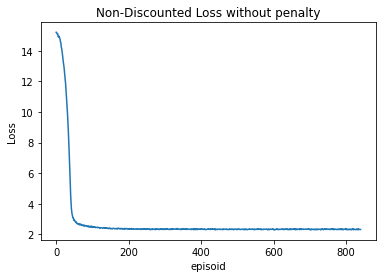

In [ ]:
plt.plot(Loss_record)
plt.xlabel('episoid')
plt.ylabel('Loss')
plt.title('Non-Discounted Loss without penalty')

# Simulate

In [ ]:
def Action(state,model,env):
    
    w_plus=K.dot(tf.math.square(model.variables[0]),cell.w_recover)
    b_plus=K.dot(-tf.math.square(model.variables[1]),cell.b_recover)
    w_minus=K.dot(-tf.math.square(model.variables[2]),cell.w_recover)
    b_minus=K.dot(-tf.math.square(model.variables[3]),cell.b_recover)
    nonlinear_plus=K.sum(K.relu(K.dot(tf.linalg.diag(state@env.select_w),cell.ones_frequency)+b_plus)\
                    *w_plus,axis=2)  
    nonlinear_minus=K.sum(K.relu(-K.dot(tf.linalg.diag(state@env.select_w),cell.ones_frequency)+b_minus)\
                    *w_minus,axis=2)  
    action_nonconstrain= nonlinear_plus+nonlinear_minus

    action=env.max_action-K.relu(env.max_action-action_nonconstrain)+K.relu(-env.max_action-action_nonconstrain)
    return action


[[42.729187]]


Text(0, 0.5, 'w (p.u.)')

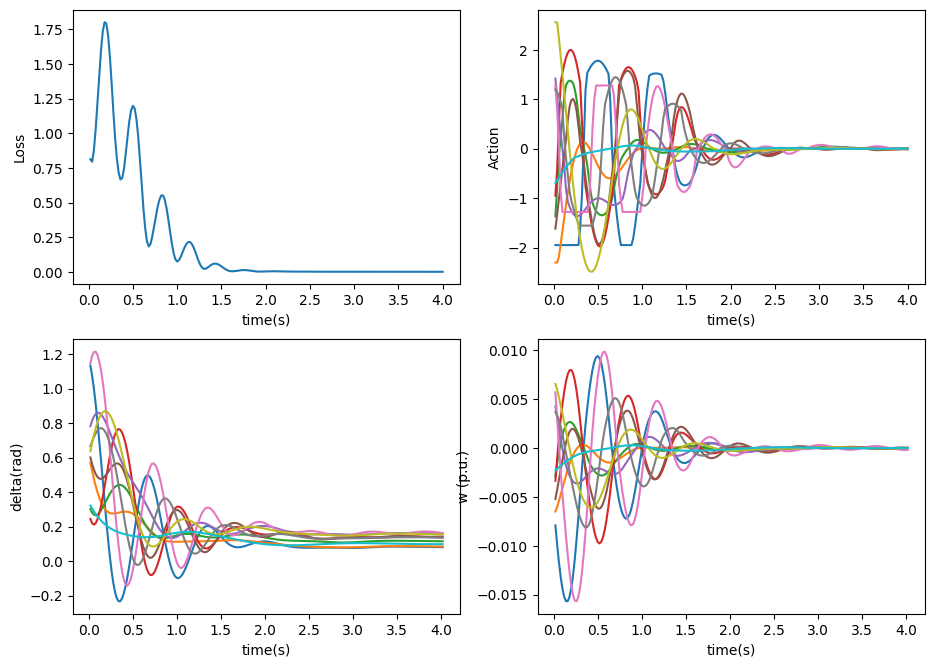

In [ ]:
# Compare the trajectory
Trajectory_RNN=[] 

init_state=np.array([[ 1.1333444 ,  0.57139003,  0.3024162 ,  0.24438968,  0.7826103 ,
         0.60109675,  1.1477319 ,  0.6663783 ,  0.63693243,  0.321338  ,
        -0.47548145, -0.38976735, -0.17346287, -0.20113388,  0.25583056,
        -0.31234026,  0.34173286,  0.22123638,  0.39272344, -0.13745056]],dtype=np.float32)

# init_state=env.reset()
s=init_state
env.set_state(s)
Trajectory_RNN.append(s)
SimulationLength=200
Record_u=[]
Record_Loss=[]
Loss_RNN=0
Loss_RNN_discounted=0
for i in range(SimulationLength):
    u=np.squeeze(Action(s,layer,env))
    next_s, r= env.step(u)
    Loss_RNN_discounted+=r
    Loss_RNN+=r
    s=next_s
    Trajectory_RNN.append(s)
    Record_u.append(u)
    Record_Loss.append(np.squeeze(r))

    
Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
plt.figure(figsize=(11, 8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u)
plt.xlabel('time(s)')
plt.ylabel('Action')

plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2]/60)
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')

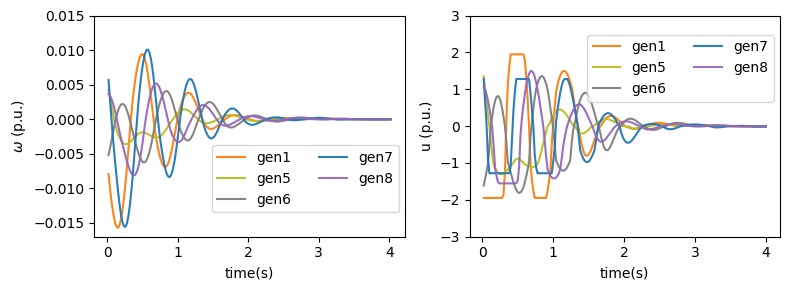

In [ ]:
Gen_select=np.array([0,4,5,6,7])
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#ff7f0e','#bcbd22',  '#7f7f7f', '#1f77b4','#9467bd','#e377c2',   '#8c564b','#d62728', '#2ca02c',  '#17becf'])

fig=plt.figure(figsize=(8, 3), dpi=100)

plt.subplot(1,2,1)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
y_major_locator=plt.MultipleLocator(0.01)

plt.plot(TimeRecord,Trajectory_RNN[:,action_units+Gen_select]/60,alpha=.95)
plt.xlabel('time(s)')
plt.ylabel('$\omega$ (p.u.)')
plt.ylim(-0.017, 0.015)

# ax.yaxis.set_major_locator(y_major_locator)

plt.legend(['gen1','gen5','gen6','gen7','gen8'],ncol=2,bbox_to_anchor=(0.98, 0.11), loc='lower right', borderaxespad=0.)

plt.subplot(1,2,2)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
Record_u=np.squeeze(np.asarray(Record_u))

plt.plot(TimeRecord,Record_u[:,Gen_select],alpha=.95)
plt.xlabel('time(s)')
plt.ylabel('u (p.u.)')
plt.ylim(-3., 3.)

plt.legend(['gen1','gen5','gen6','gen7','gen8'],ncol=2,bbox_to_anchor=(0.98, 0.61), loc='lower right', borderaxespad=0.)
fig.tight_layout()    
# plt.savefig('figure/Dynamic_RNN.png', bbox_inches='tight', dpi=900)  


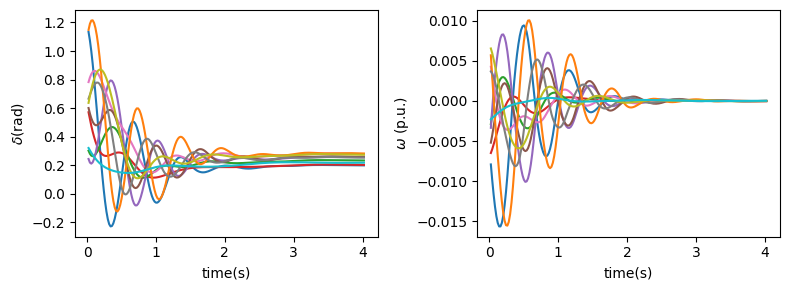

In [ ]:

mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4','#d62728',  '#2ca02c',  '#9467bd', '#e377c2','#8c564b', '#ff7f0e', '#7f7f7f', '#bcbd22', '#17becf'])

fig=plt.figure(figsize=(8, 3), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(1,2,1)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_RNN[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('$\delta$(rad)')


plt.subplot(1,2,2)
plt.plot(TimeRecord,Trajectory_RNN[:,action_units:action_units*2]/60)
plt.xlabel('time(s)')
plt.ylabel('$\omega$ (p.u.)')

fig.tight_layout() 
# plt.savefig('figure/Dynamic_RNN_Full.png', bbox_inches='tight', dpi=900)  


Text(0, 0.5, 'w (p.u.)')

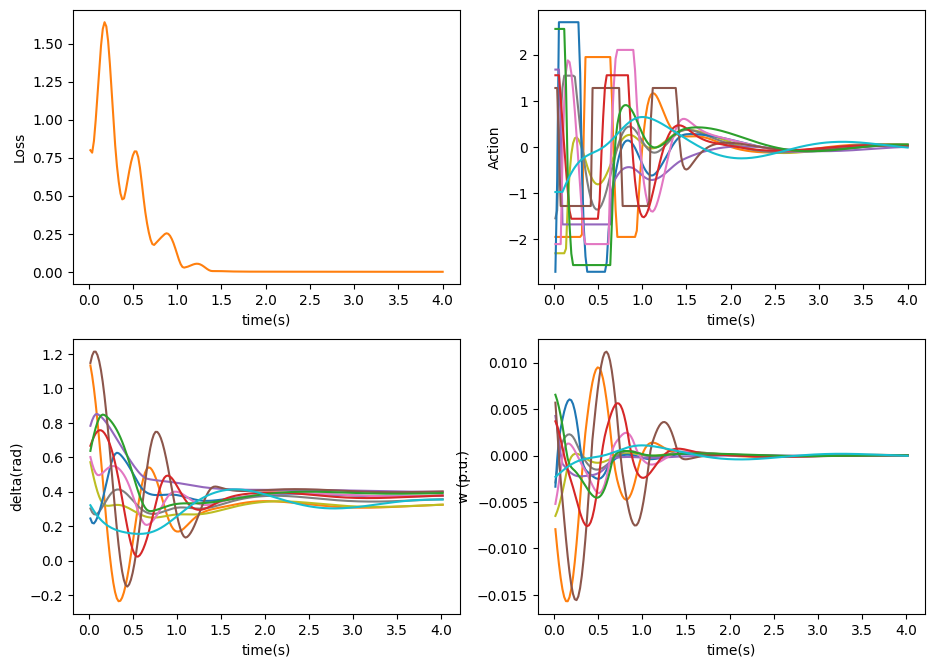

In [ ]:
# Compare the trajectory
init_state=np.array([[ 1.1333444 ,  0.57139003,  0.3024162 ,  0.24438968,  0.7826103 ,
         0.60109675,  1.1477319 ,  0.6663783 ,  0.63693243,  0.321338  ,
        -0.47548145, -0.38976735, -0.17346287, -0.20113388,  0.25583056,
        -0.31234026,  0.34173286,  0.22123638,  0.39272344, -0.13745056]],dtype=np.float32)


Trajectory_Linear=[]  
s=init_state
env.set_state(s)
Trajectory_Linear.append(s)
SimulationLength=200
Record_u_Linear=[]
Record_Loss_Linear=[]
Loss_Linear=0
for i in range(SimulationLength):
    u=np.squeeze(Action_linear(s,linear_coff,env))
    next_s, r= env.step(u)
    Loss_Linear+=r
    s=next_s
    Trajectory_Linear.append(s)
    Record_u_Linear.append(u)
    Record_Loss_Linear.append(np.squeeze(r))

Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
plt.figure(figsize=(11,8), dpi=100)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
plt.subplot(2,2,1)

plt.plot(TimeRecord,Record_Loss_Linear)
plt.xlabel('time(s)')
plt.ylabel('Loss')

plt.subplot(2,2,2)

plt.plot(TimeRecord,Record_u_Linear)
plt.xlabel('time(s)')
plt.ylabel('Action')
plt.subplot(2,2,3)

TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
plt.plot(TimeRecord,Trajectory_Linear[:,0:action_units])
plt.xlabel('time(s)')
plt.ylabel('delta(rad)')


plt.subplot(2,2,4)
plt.plot(TimeRecord,Trajectory_Linear[:,action_units:action_units*2]/60)
plt.xlabel('time(s)')
plt.ylabel('w (p.u.)')

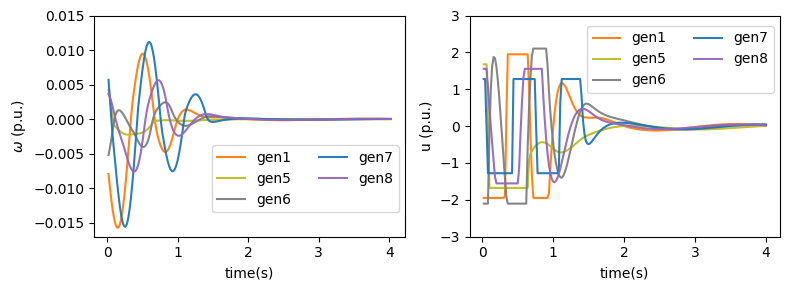

In [ ]:
fig=plt.figure(figsize=(8, 3), dpi=100)
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#ff7f0e','#bcbd22',  '#7f7f7f', '#1f77b4','#9467bd','#e377c2',   '#8c564b','#d62728', '#2ca02c',  '#17becf'])

plt.subplot(1,2,1)
TimeRecord=np.arange(1,SimulationLength+2)
TimeRecord=env.delta_t*TimeRecord
y_major_locator=plt.MultipleLocator(0.01)

plt.plot(TimeRecord,Trajectory_Linear[:,action_units+Gen_select]/60,alpha=.95)
plt.xlabel('time(s)')
plt.ylabel('$\omega$ (p.u.)')
plt.ylim(-0.017, 0.015)

plt.legend(['gen1','gen5','gen6','gen7','gen8'],ncol=2,bbox_to_anchor=(0.98, 0.11), loc='lower right', borderaxespad=0.)

plt.subplot(1,2,2)
TimeRecord=np.arange(1,SimulationLength+1)
TimeRecord=env.delta_t*TimeRecord
Record_u_Linear=np.squeeze(np.asarray(Record_u_Linear))

plt.plot(TimeRecord,Record_u_Linear[:,Gen_select],alpha=.95)
plt.xlabel('time(s)')
plt.ylabel('u (p.u.)')
plt.ylim(-3, 3.)

plt.legend(['gen1','gen5','gen6','gen7','gen8'],ncol=2,bbox_to_anchor=(0.98, 0.65), loc='lower right', borderaxespad=0.)


fig.tight_layout()    

# plt.savefig('figure/Dynamic_Linear.png', bbox_inches='tight', dpi=900)  




# Loss Statistic

In [ ]:

TestNum=100
RNN_better=0
RNN_equal=0
gen_idx=0
SimulationLength=T
Sum_Loss_RNN=0
Sum_Loss_Linear=0
Bound_w_list=np.arange(0.0,0.05,0.01,dtype=np.float32)*60
Sample_Record_Loss_RNN_3d=np.zeros((len(Bound_w_list),TestNum))
Sample_Record_Loss_Linear_3d=np.zeros((len(Bound_w_list),TestNum))

for iw in range(len(Bound_w_list)):
    RNN_better=0
    Sum_Loss_Linear=0
    Sum_Loss_RNN=0
    for itest in range(TestNum):
        initial_state1=np.random.uniform(-2.,2.,(1,action_units))
        initial_state2=np.random.uniform(-Bound_w_list[iw],Bound_w_list[iw],(1,action_units))
        s_concate=np.hstack((initial_state1,initial_state2)).astype(np.float32)+equilibrium_init
        Record_Loss_RNN=[]
        env.set_state(s_concate)
        s=copy.deepcopy(s_concate)
        Loss_RNN=0
        Loss_RNN_action=0
        Trajectory_RNN=[]
        for i in np.arange(1,SimulationLength,1):
            u=Action(s,model,env)
            next_s, r= env.step(u)
            Loss_RNN+=r+env.Penalty_action*np.sum(u**2)
            Loss_RNN_action+=env.Penalty_action*np.sum(u**2)
            s=next_s
            Trajectory_RNN.append(s)
        Trajectory_RNN=np.squeeze(np.asarray(Trajectory_RNN))
        Record_Loss_RNN=np.sum(np.max(abs(Trajectory_RNN@env.select_w),axis=0))+Loss_RNN_action

        Record_Loss_Linear=[]
        env.set_state(s_concate)
        s=copy.deepcopy(s_concate)
        Loss_RNN_Linear=0
        Loss_Linear_action=0
        Trajectory_Linear=[]
        for i in np.arange(1,SimulationLength,1):
            u=Action_linear(s,linear_coff,env)
            next_s, r= env.step(u)
            Loss_RNN_Linear+=r+env.Penalty_action*np.sum(u**2)
            Loss_Linear_action+=env.Penalty_action*np.sum(u**2)
            s=next_s
            Trajectory_Linear.append(s)
        Trajectory_Linear=np.squeeze(np.asarray(Trajectory_Linear))
        Record_Loss_Linear=np.sum(np.max(abs(Trajectory_Linear@env.select_w),axis=0))+Loss_Linear_action

        Sample_Record_Loss_RNN_3d[iw,itest]=Record_Loss_RNN
        Sample_Record_Loss_Linear_3d[iw,itest]=Record_Loss_Linear


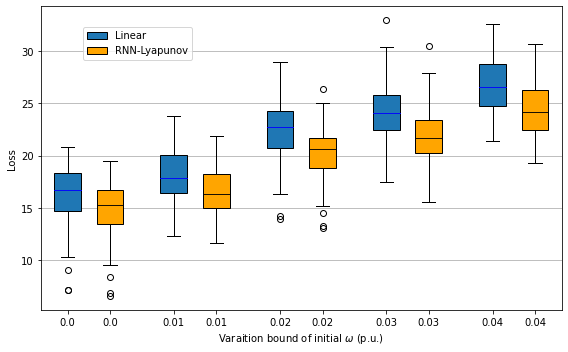

In [ ]:
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)
labels =['0.0','0.01','0.02','0.03','0.04']
# labels =['1','2','3']
line_props = dict(color="b", alpha=0.3)
bbox_props = dict(color="b", alpha=0.9)
mean_props = dict(color="b", alpha=0.9)
flier_props = dict(marker="o", markersize=7)
left_positions=[-0.4,  1.6,  3.6, 5.6,7.6]
right_positions=[0.4, 2.4, 4.4, 6.4,8.4]
bp1 = plt.boxplot(Sample_Record_Loss_Linear_3d.T, positions = left_positions,patch_artist=True,medianprops=dict(color="b", alpha=0.9),labels=labels)
bp2=plt.boxplot(Sample_Record_Loss_RNN_3d.T, positions = right_positions,patch_artist=True,boxprops=dict(facecolor="orange"), medianprops=dict(color="black", alpha=0.9),labels=labels)

ax.yaxis.grid(True)
ax.set_xlabel('Varaition bound of initial $\omega$ (p.u.)')
ax.set_ylabel('Loss')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Linear', 'RNN-Lyapunov'], loc='upper right', bbox_to_anchor=(0.3, 0.95))
# ax.set_ylim(1.25, 1.55)
fig.tight_layout()    


# plt.savefig('/figure/Loss_Mono_Linear.png', bbox_inches='tight', dpi=900)  


# Plot action


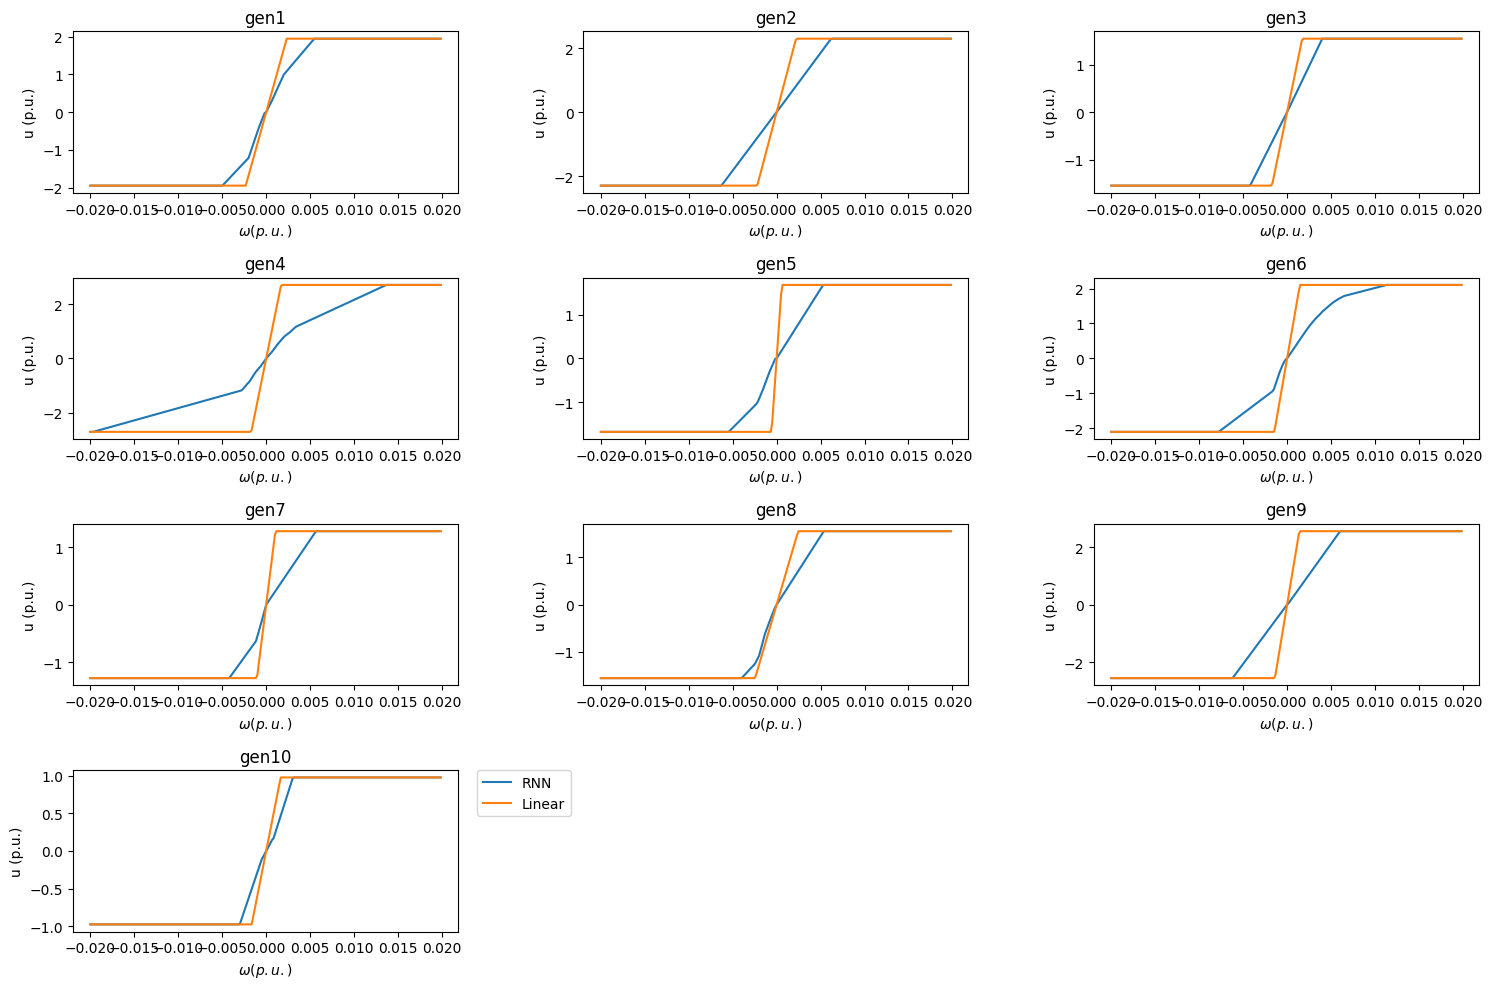

In [ ]:
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

initial_state1=np.random.uniform(0.0,0.3,(1,action_units))
initial_state2=np.random.uniform(-0.03,0.03,(1,action_units))
s_concate0=np.hstack((initial_state1,initial_state2)).astype(np.float32)
state_d=np.float32(0.2)

state_w=np.arange(-1.2,1.2,0.01,dtype=np.float32)
state_d2=np.float32(0.03)
state_w2=np.float32(0.02)

action_dw=np.zeros(len(state_w))
action_dw_linear=np.zeros(len(state_w))

fig=plt.figure(figsize=(15,10), dpi=100)
plt.subplot(2,2,1)
for idx_plot in range(action_units):
    gen_idx=idx_plot
    s_concate=copy.deepcopy(s_concate0)
    for j in range(len(state_w)):
            s_concate[0,action_units+gen_idx]=state_w[j]
            u=Action(s_concate,layer,env)
            u_linear=Action_linear(s_concate,linear_coff,env)
            action_dw[j]=u[0][gen_idx]
            action_dw_linear[j]=u_linear[0][gen_idx]
    plt.subplot(np.ceil(action_units/3),3,idx_plot+1)
    plt.plot(state_w/60,action_dw, label='RNN')
    plt.plot(state_w/60,action_dw_linear, label='Linear')
    plt.title('gen'+str(idx_plot+1))
    plt.xlabel('$\omega (p.u.)$')
    plt.ylabel('u (p.u.)') 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
fig.tight_layout()    


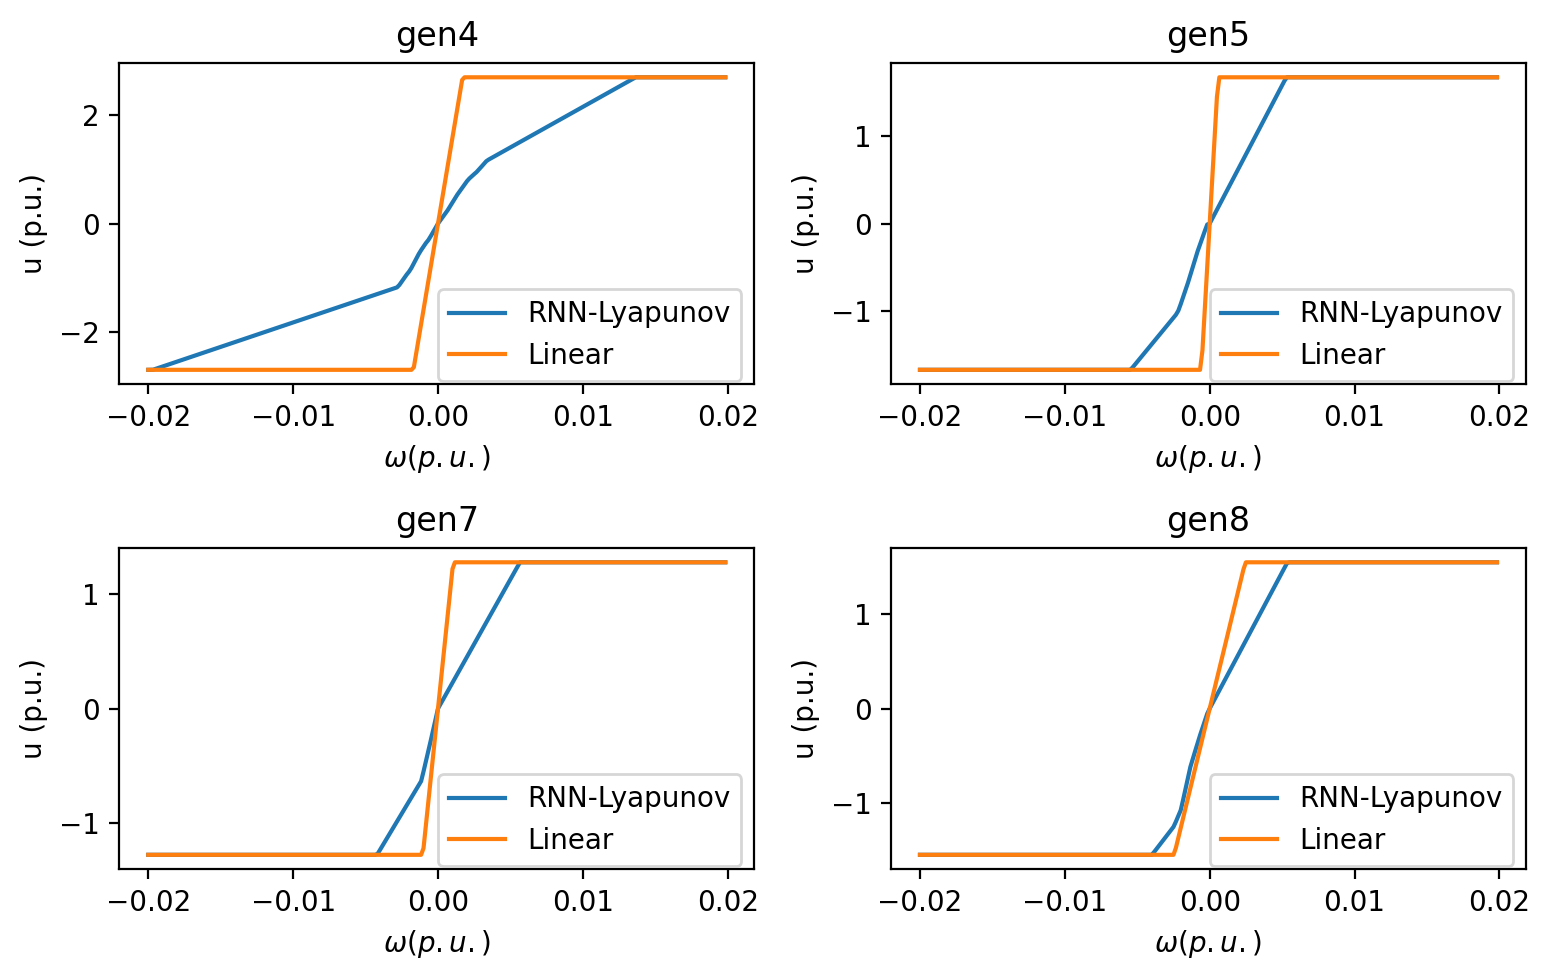

In [ ]:
# plot the figures for action in selected buses
initial_state1=np.random.uniform(0.0,0.3,(1,action_units))
initial_state2=np.random.uniform(-0.03,0.03,(1,action_units))
s_concate0=np.hstack((initial_state1,initial_state2)).astype(np.float32)
state_d=np.float32(0.2)

state_w=np.arange(-1.2,1.2,0.01,dtype=np.float32)
state_d2=np.float32(0.03)
state_w2=np.float32(0.02)

action_dw=np.zeros(len(state_w))
action_dw_linear=np.zeros(len(state_w))
gen_idx_list=[4,5,7,8]
fig=plt.figure(figsize=(8,5), dpi=200)
# plt.subplot(2,2,1)
for idx_plot in range(len(gen_idx_list)):
    gen_idx=gen_idx_list[ idx_plot]-1
    s_concate=copy.deepcopy(s_concate0)
    for j in range(len(state_w)):
            s_concate[0,action_units+gen_idx]=state_w[j]
            u=Action(s_concate,layer,env)
            u_linear=Action_linear(s_concate,linear_coff,env)
            action_dw[j]=u[0][gen_idx]
            action_dw_linear[j]=u_linear[0][gen_idx]
    plt.subplot(2,2,idx_plot+1)
    plt.plot(state_w/60,action_dw, label='RNN-Lyapunov')
    plt.plot(state_w/60,action_dw_linear, label='Linear')
    plt.xlabel('$\omega (p.u.)$')
    plt.ylabel('u (p.u.)') 
    plt.title('gen'+str(gen_idx+1))
    plt.legend(bbox_to_anchor=(0.98, 0.01), loc='lower right', borderaxespad=0.)
fig.tight_layout()    
plt.savefig('/figure/Action_Mono.png', bbox_inches='tight', dpi=300)  
